In [1]:
# Veriyi okuma ve işleme için kütüphaneler
import cv2 as cv
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen


In [2]:
# Warningleri kapamak için kütüphaneler
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Model değerlendirme için kullanılacak kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Model için kullanılacak kütüphaneler
import tensorflow as tf
from keras.models import Sequential,load_model
from keras.metrics import FBetaScore
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D,Flatten,MaxPool2D,Dense,Dropout,SpatialDropout2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [5]:

# Veri seti okunması

path_data = "D:\Derin Ogrenme\CNN\Garbage_Data\Garbage classification"
target_size = (224,224)
# burdaki işlem kritik bir işlem path içindeki her dosya adını encode etmemize sağlayacak sözlük yapısı
waste_labels = {'cardboard':0,'glass':1,'metal':2,'paper':3,'plastic':4,'trash':5}

def load_datasets(path):
    """ path: görsellerin bulunduğu dizini ifade eder.
        return:
        x: görüntülere ait matris bilgilerini tutar
        labels: görüntünün ait olduğu sinif bilgisini tutar."""
    x = []
    labels = []

    # Gönderdiğimiz path içindeki görüntüleri listeleyip sıralamaktadır.
    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        # Belirtilen pathdeki görüntüler openCV ile okunmaktadır.
        img = cv.imread(image_path)

        # Görüntüleri başlangıç durumundan farklı olarak resize göre yeniden ölçeklendirme
        # Başlangıç 512x384  Resize 224x224
        img = cv.resize(img,target_size)

        # x listesine ekleme
        x.append(img)

        # Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labeldır.
        label = image_path.split(os.path.sep)[-2]
        

        # Yakalanan labeller daha önceki dict göre sayısal değerlere karşılık gelen key olarak listeye ekleniyor.
        labels.append(waste_labels[label])

    # Veri setinini random bir şekilde karıştır.
    x,labels = shuffle(x,labels,random_state=42)

    # Boyut ve sınıf bilgisi raporlanmaktadır.
    print(f'X boyutu : {np.array(x).shape}')
    print(f'Label sinif sayisi: {len(np.unique(labels))} Gözlem sayisi: {len(labels)}')

    return x, labels
    
x,labels = load_datasets(path=path_data)

X boyutu : (2527, 224, 224, 3)
Label sinif sayisi: 6 Gözlem sayisi: 2527


In [6]:
def visualize_img(image_batch, label_batch):
    """image_batch: görüntülere ait matris bilgilerini tutar.
       label_batch: görüntünün ait olduğu sinif bilgisini tutan liste"""
    
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
        plt.axis('off')

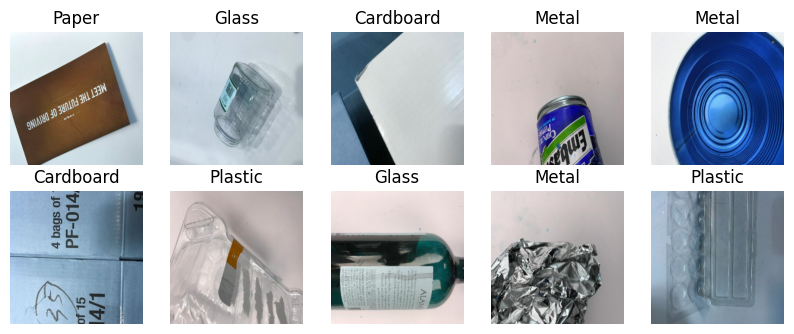

In [7]:
visualize_img(x,labels)

In [8]:
# Veriyi hazırlama

train = ImageDataGenerator(horizontal_flip=True, #görevi veri üretmektir. veri çeşitlendirmeyi sağlar.
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range= 0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

#width_shift_range ve height_shift_range argümanları ile görüntü kaydırma
#horizontal_flip ve vertical_flip argümanları ile görüntü çevirme
#zoom_range argümanı ile görüntü yakınlaştırma
#rotation_range argümanı ile rastgele görüntü çevirme
#brightness_range argümanı ile parlaklık ayarı
#shear_range argümanı görüntünün şekline eğim vermek için kullanılır.

test = ImageDataGenerator(rescale=1/255,validation_split=0.1)

In [9]:
train_generator = train.flow_from_directory(directory=path_data,
                                           target_size=(target_size),
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           subset='training',
                                           )

test_generator = test.flow_from_directory(directory=path_data,
                                           target_size=(target_size),
                                           batch_size=25,
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           subset='validation',
                                           )

# Veriyi bu yapıları sayesinde hazırlıyoruz
# Eğer class mode da sınıfımız iki adet ise binary kullanmamız gerek
# ve alt kümelerde yaşanacak işlemler için training ve validation olduğunu belirlemeliyiz

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [10]:
# modeli kurma aşaması
model = Sequential()  # sinir ağı kurma yöntemidir. Sıralı katmanlardan oluşan bir ağ kurabiliriz.
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape = (224,224,3), activation='relu')) #filters görüntü üstünde gezicel filtre sayısını kernel filtrelerin boyutunu paddingte same giriş ve çıkış matrisi aynı boyutta olucak demektir.
model.add(MaxPool2D(pool_size=2,strides=(2,2))) # boyut azaltmak için kullanılır her pikseldeki maksimumu alır

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape = (224,224,3), activation='relu')) #filters görüntü üstünde gezicel filtre sayısını kernel filtrelerin boyutunu paddingte same giriş ve çıkış matrisi aynı boyutta olucak demektir.
model.add(MaxPool2D(pool_size=2,strides=(2,2))) # boyut azaltmak için kullanılır her pikseldeki maksimumu alır

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape = (224,224,3), activation='relu')) #filters görüntü üstünde gezicel filtre sayısını kernel filtrelerin boyutunu paddingte same giriş ve çıkış matrisi aynı boyutta olucak demektir.
model.add(MaxPool2D(pool_size=2,strides=(2,2))) # boyut azaltmak için kullanılır her pikseldeki maksimumu alır

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape = (224,224,3), activation='relu')) #filters görüntü üstünde gezicel filtre sayısını kernel filtrelerin boyutunu paddingte same giriş ve çıkış matrisi aynı boyutta olucak demektir.
model.add(MaxPool2D(pool_size=2,strides=(2,2))) # boyut azaltmak için kullanılır her pikseldeki maksimumu alır

model.add(Flatten()) # veriyi 2 boyuttan tek boyutlu hale çevirip sinir ağına iletir.

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.4)) # aşırı öğrenmenin önüne geçen katman

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.4))

model.add(Dense(units=6,activation='softmax')) # çıkış katmanı 6 tane nöron çünkü 6 sınıflı bir sııflandırma problemi

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

In [11]:
model.compile(loss="categorical_crossentropy", optimizer="adam", 
              metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.F1Score(),
                       tf.keras.metrics.Precision(),"accuracy"],run_eagerly=True)

In [12]:
callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode="min"),
             ModelCheckpoint(filepath='katiatik.h5',monitor='val_loss',mode='min', save_best_only=True, save_weights_only=False,verbose=1)]

callbacks

* Sinir Ağını eğitirken aşırı öğrenmesi için bazı önlemler almamız gerek bunlardan biri Dropout katmanı eklemek ama işimiz bununla bitmiyor, EarlyStopping yapısı bize eğer model eğitim ve doğrulama etkinliklerinde bir uçurum baş göstermeye başlarsa yani overfitting yaparsa işlemi erkenden durdurmamıza yol açıyor. monitor burada hangi metriğe göre overfitting takip etmemiz gerektiğni gösterir. patience ise kaçıncı adım başı bu işlem olucak onu söyler burada 50. adıma kadar herhangi bir pozitif ilerleme olmaz ise işlemi keser. mode bilgisi model bilgisinin takip edileceği parametre bilgisi minse izlenen paramtre min artış durduğunda durur maxta artışta durma  otomatikte otomatik.

* Model iterasyonları devam ederken yakalanacak en iyi modelin kaydedilmesi için ModelCheckpoint kullanırız. Yukarıdaki ifade en iyi modeli kayıt etmeye yarar. En düşük hatayı nerede alırsa ona göre modeli kayıt edecek.

In [13]:
history = model.fit(
    train_generator,
    epochs=120, 
    validation_data=test_generator, 
    callbacks=callbacks, 
    workers=8,
    steps_per_epoch=2276//32,
    validation_steps=251//32) # workers paralel olarak gruplar oluşturan iş parçacığı sayısıdır. CPU hesaplanıp GPU iletilir donanımsaldır.



Epoch 1/120
71/71 [==============================] - ETA: 0s - loss: 1.7653 - recall: 0.0000e+00 - f1_score: 0.1563 - precision: 0.0000e+00 - accuracy: 0.2037
Epoch 1: val_loss improved from inf to 1.72535, saving model to katiatik.h5
71/71 [==============================] - 164s 2s/step - loss: 1.7653 - recall: 0.0000e+00 - f1_score: 0.1563 - precision: 0.0000e+00 - accuracy: 0.2037 - val_loss: 1.7254 - val_recall: 0.0000e+00 - val_f1_score: 0.0670 - val_precision: 0.0000e+00 - val_accuracy: 0.2514
Epoch 2/120
71/71 [==============================] - ETA: 0s - loss: 1.7084 - recall: 0.0040 - f1_score: 0.1579 - precision: 0.4286 - accuracy: 0.2326
Epoch 2: val_loss improved from 1.72535 to 1.63997, saving model to katiatik.h5
71/71 [==============================] - 198s 3s/step - loss: 1.7084 - recall: 0.0040 - f1_score: 0.1579 - precision: 0.4286 - accuracy: 0.2326 - val_loss: 1.6400 - val_recall: 0.0000e+00 - val_f1_score: 0.1745 - val_precision: 0.0000e+00 - val_accuracy: 0.2743
Ep

Text(0.5, 1.0, 'Training and Validation Accuracy')

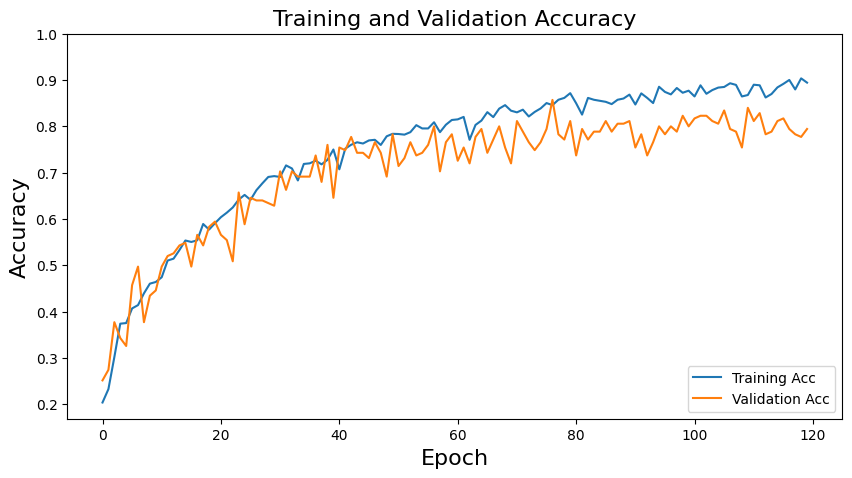

In [14]:
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy", fontsize=16)


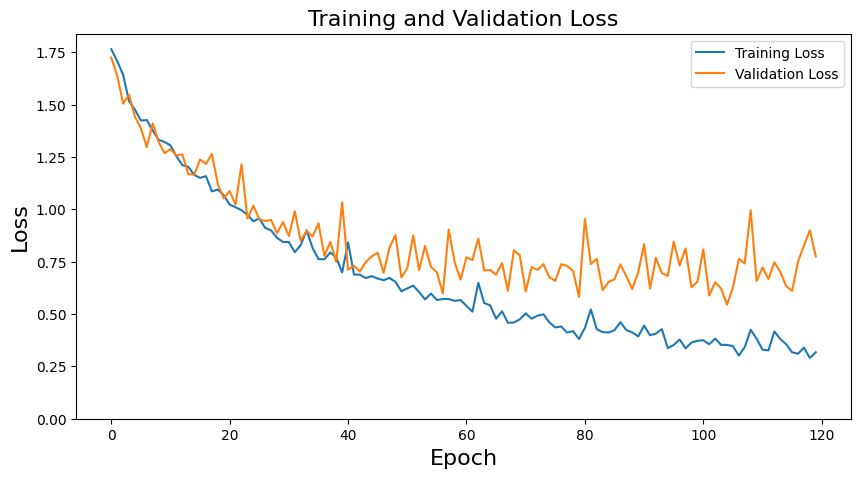

In [15]:
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)
plt.show()

In [37]:

loss, precision, recall, f1_score, acc = model.evaluate(test_generator, batch_size=32)

11/11 [==============================] - 5s 418ms/step - loss: 0.6803 - recall: 0.7888 - f1_score: 0.7970 - precision: 0.8354 - accuracy: 0.8127


In [38]:
print("\nTest Acc: %.1f%%" % (100.0 * acc))
print("\nTest Loss: %.1f%%" % (100.0 * loss))
print("\nTest Precision: %.1f%%" % (100.0 * precision))
print("\nTest Recall: %.1f%%" % (100.0 * np.mean(recall)))
print("\nTest F1-score: %.1f%%" % (100.0 * f1_score))




Test Acc: 81.3%

Test Loss: 68.0%

Test Precision: 78.9%

Test Recall: 79.7%

Test F1-score: 83.5%


In [39]:
x_test,y_test = test_generator.next()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis= 1)

y_test = np.argmax(y_test, axis= 1)

target_names = list(waste_labels.keys())

print(classification_report(y_test, y_pred, target_names= target_names)) 




1/1 [==============================] - 0s 416ms/step
              precision    recall  f1-score   support

   cardboard       1.00      0.83      0.91         6
       glass       0.62      0.83      0.71         6
       metal       0.60      0.75      0.67         4
       paper       1.00      0.50      0.67         2
     plastic       0.75      0.60      0.67         5
       trash       0.50      0.50      0.50         2

    accuracy                           0.72        25
   macro avg       0.75      0.67      0.69        25
weighted avg       0.76      0.72      0.72        25



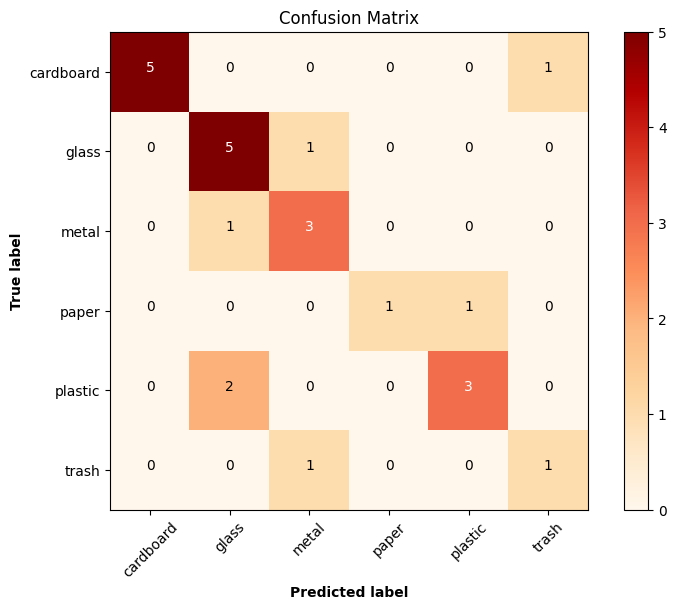

In [40]:
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap= plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[1, np.newaxis]
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes , rotation = 45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j , i , format(cm[i,j], fmt),
        horizontalalignment = 'center',
        color = 'white' if cm[i , j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label' , fontweight = 'bold')
    plt.xlabel('Predicted label' , fontweight = 'bold')

plot_confusion_matrix(cm,waste_labels.keys(), title = 'Confusion Matrix' , cmap=plt.cm.OrRd)
